In [1]:
import datetime
import requests
import pandas
import unlzw3
import os
from pathlib import Path
from io import StringIO 
from datetime import date
from astropy.io import fits
from urllib.request import urlretrieve
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline

In [5]:
today_dt = date.today()
if datetime.datetime.now().hour < 10: today_dt = today_dt - datetime.timedelta(days=1)
today = today_dt.strftime(format="%Y %m %d").replace(" ","%20")
# more dates can be added or sustracted
files_dict = {'now': {'date':today, 'filename': 'FEROS_NOW'}, 'ref1': {'date':"2021%2009%2006",'filename':'FEROS_REFERENCE_1'}, 'ref2': {'date':"2018%2005%2010",'filename':'FEROS_REFERENCE_2'}}


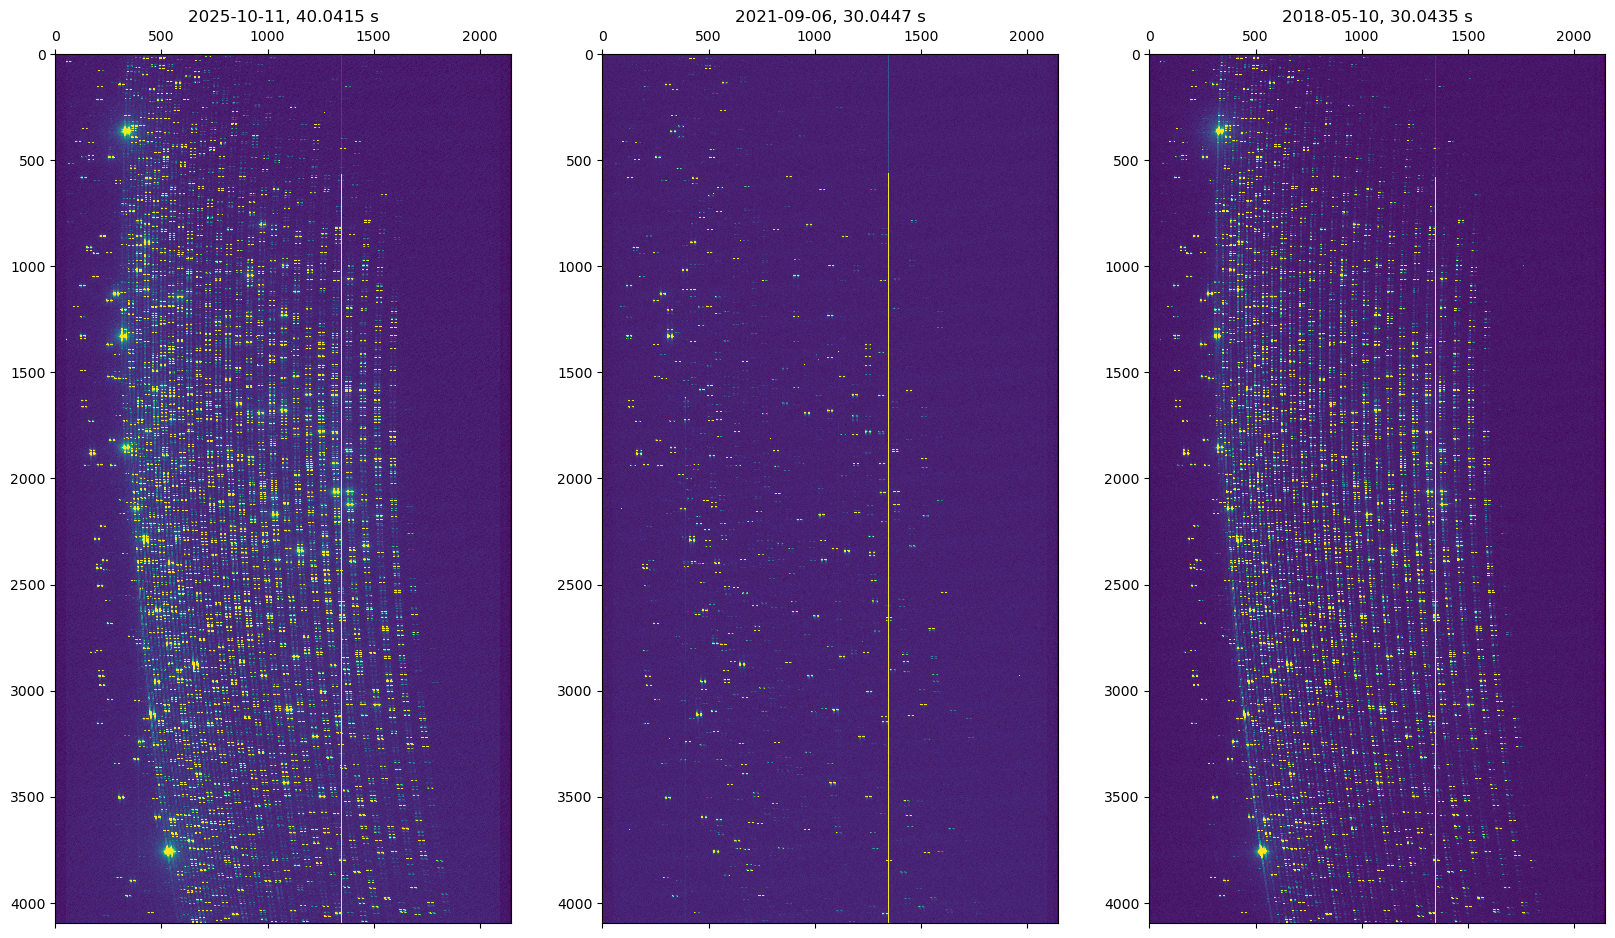

In [16]:
vmin=240;vmax=370
keys = files_dict.keys()
fig,ax=plt.subplots(nrows=1,ncols=len(keys),figsize=(20, 20))
for a,k in zip(ax,keys):
 # step one: query ESO on each date
  url = f"""https://archive.eso.org/wdb/wdb/eso/eso_archive_main/query?wdbo=csv&max_rows_returned=200&instrument=FEROS
&tab_object=on&target=&resolver=simbad&ra=&dec=&box=00%2010%2000&degrees_or_hours=hours&tab_target_coord=on
&format=SexaHour&wdb_input_file=&tab_night=on&night={files_dict[k]['date']}&stime=&starttime=12&etime=&endtime=12
&tab_prog_id=on&prog_id=&gto=&pi_coi=&obs_mode=&title=&image[]=GROND&image[]=WFI&spectrum[]=FEROS
&tab_dp_cat=on&dp_cat=CALIB&tab_dp_type=on&dp_type=WAVE&dp_type_user=&tab_dp_tech=on&dp_tech=
&dp_tech_user=&tab_dp_id=on&dp_id=&origfile=&tab_rel_date=on&rel_date=&obs_name=&ob_id=&tab_tpl_start=on
&tpl_start=&tab_tpl_id=on&tpl_id=&tab_exptime=on&exptime=&tab_filter_path=on&filter_path=&tab_wavelength_input=on
&wavelength_input=&tab_fwhm_input=on&fwhm_input=&gris_path=&grat_path=&slit_path=&tab_instrument=on
&tab_tel_airm_start=on&tab_stat_instrument=on&tab_ambient=on&tab_stat_exptime=on&tab_HDR=on&tab_mjd_obs=on
&aladin_colour=aladin_instrument&order=tpl_start&"""
  _response = requests.get(url)
  response = _response.text
  observed_data = pandas.read_table(StringIO(response),sep=",")
 # step two: get last file with  30s < exptime < 60s
  observed_data = observed_data[observed_data["Exptime"]>=30]
  observed_data = observed_data[observed_data["Exptime"]<=60]
  url = 'https://dataportal.eso.org/dataPortal/file/' + observed_data.iloc[-1]["Dataset ID"]
 # step three: download, unzip and create file
  filename = files_dict[k]["filename"]
  filename_zip = filename+".Z"
  urlretrieve(url, filename=filename_zip)
  extracted_data = unlzw3.unlzw(Path(filename_zip))
  filename_fits = filename+".fits"
  if os.path.exists(filename_fits): os.remove(filename_fits)
  file_now = open(filename_fits,"wb")
  file_now.write(extracted_data)
  file_now.close()
 # step four: extract and plot data 
  hdu = fits.open(filename_fits,ignore_missing_simple=True)
  header = hdu[0].header
  a.matshow(hdu[0].data,vmin=vmin,vmax=vmax)
  a.set_title(f"{(header['DATE']).split('T')[0]}, {header['EXPTIME']} s")